# <div align="center"><b> Convolutional Vision Transformer (CvT)</b></div>

<div align="right">

<!-- [![Binder](http://mybinder.org/badge.svg)](https://mybinder.org/) -->
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange?logo=Jupyter)](https://nbviewer.org/github/brunomaso1/vision-transformer/blob/main/notebooks/3.02-cvt.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/brunomaso1/vision-transformer/blob/main/notebooks/3.02-cvt.ipynb)

</div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻


Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:

```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:

```powershell
poetry install
Invoke-Expression (poetry env activate)
```

> 📝 <em><font color='Gray'>Nota:</font></em> Para agregar `pytorch` utilizando Poetry, se utiliza el siguiente comando:
> ```bash
> # Más info: https://github.com/python-poetry/poetry/issues/6409
> poetry source add --priority explicit pytorch_gpu https://download.pytorch.org/whl/cu128 # Seleccionar la wheel adecuada para tu GPU
> poetry add --source pytorch_gpu torch torchvision 
> ```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [ ]:
# Recarga automática de módulos en Jupyter Notebook
%reload_ext autoreload
%autoreload 2

# Recarga automática de módulos en Jupyter Notebook
import random, requests, os
from loguru import logger
import pandas as pd
from PIL import Image

# PyTorch
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms

# NumPy y utilidades
import numpy as np

# Evaluación
import evaluate

# Modelos y procesamiento de imágenes (Transformers)
from transformers import (
    AutoImageProcessor,
    CvtForImageClassification,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    # Swinv2ForImageClassification,  # Descomentar si se usa explícitamente
)
from transformers.integrations import MLflowCallback

# Módulos propios
from vision_transformer.plots import show_image_grid, plot_confusion_matrix, plot_metric
from vision_transformer.dataset import load_huggingface_dataset
from vision_transformer.features import CVTTransforms
from vision_transformer.utils import MulticlassAccuracy
from vision_transformer.config import (
    RANDOM_SEED,
    MODELS_DIR,
    FIGURES_DIR,
    MODELS_DIR_CVT_21,
    METRICS_FILENAME,
    HISTORY_FILENAME,
    PREDICTIONS_FILENAME,
    MLFLOW_URL,
    DATASET_NAME,
    DATASET_VERSION,
    MODEL_NAME_CVT_21,
    PREFECT_URL
)

import mlflow

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [ ]:
random.seed(RANDOM_SEED)  # Establece la semilla para la reproducibilidad.
TESTING_MODE = False  # Modo de prueba, si es True, se usa un subconjunto pequeño del dataset.

BATCH_SIZE = 64

# Checkpoints a utilizar
MODEL_NAME = MODEL_NAME_CVT_21
MODEL_FOLDER = MODELS_DIR_CVT_21
CHECKPOINT = "microsoft/" + MODEL_NAME

# Optimizaciones
# # torch.set_float32_matmul_precision('highest') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'más alta'.
# torch.set_float32_matmul_precision('high') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'alta'.
# # torch.set_float32_matmul_precision('medium') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'media'.
# # torch.backends.cudnn.benchmark = True # Optimización: Para redes CNN (pero como se usa una capa convolucional, se establece en True).

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.
logger.info(f"Dispositivo actual: {DEVICE}")

# MLflow: Configuración de la URI de seguimiento
try:
    response = requests.get(MLFLOW_URL)
    response.raise_for_status()  # Verifica si la solicitud fue exitosa.
    logger.success("Conexión a MLflow establecida correctamente.")
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_URL  # Configura la URI de seguimiento de MLflow.
    os.environ["MLFLOW_EXPERIMENT_NAME"] = CHECKPOINT.replace("/", "_")  # Configura el nombre del experimento de MLflow.
    os.environ["MLFLOW_TAGS"] = '{"model_family": "swinv2"}'
except Exception as e:
    logger.error(f"Error al conectar con MLflow. Tienes levantado el servidor de MLflow?")
    raise SystemExit(f"Error al conectar con MLflow: {e}")

# Prefect: Configuración de Prefect
try:
    response = requests.get(PREFECT_URL)
    response.raise_for_status()  # Verifica si la solicitud fue exitosa.
    logger.success("Conexión a Prefect establecida correctamente.")
except Exception as e:
    logger.error(f"Error al conectar con Prefect. Tienes levantado el servidor de Prefect?")
    raise SystemExit(f"Error al conectar con Prefect: {e}")

2025-06-18 18:12:23.292 | INFO     | __main__:<module>:26 - Dispositivo actual: cuda
2025-06-18 18:12:25.296 | SUCCESS  | __main__:<module>:32 - Conexión a MLflow establecida correctamente.
2025-06-18 18:12:27.304 | SUCCESS  | __main__:<module>:44 - Conexión a Prefect establecida correctamente.


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | *Fine-tuning* del modelo swimv2 sobre el dataset EuroSAT                                                                       |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | <small>Análisis exploratorio del proceso de *fine-tuning* del swimv2 sobre el EuroSAT<br/>- *Tarea:* `Clasificación`<br/>- *Modelo*: `CvT`<br/> - *Dataset*: `EuroSAT` </small>|
<!-- | **Autor** | <small>[Nombre] ([correo]) </small>                                                                                                 | -->

</div>

## Tabla de contenidos
0. [Pasos previos](#pasos-previos)
1. [Carga de datos](#carga-de-datos)
2. [Carga del modelo](#carga-del-modelo)
3. [Preprocesamiento del dataset](#preprocesamiento)
4. [Definicion de las metricas de evaluacion](#metricas)
5. [Entrenamiento del modelo](#entrenamiento)
6. [Resultados](#resultados)

## 0. Pasos previos <a id="pasos-previos"></a>

Ejecuta desde la raíz del proyecto para descargar el dataset EuroSAT:

```bash
python -m vision_transformer.flows.test_flow
```

## 1. Carga de datos <a name="carga-de-datos"></a>

In [33]:
dataset = load_huggingface_dataset()

2025-06-18 18:12:27.447 | INFO     | vision_transformer.dataset:load_huggingface_dataset:441 - Cargando el dataset procesado...
2025-06-18 18:12:27.706 | INFO     | vision_transformer.dataset:load_huggingface_dataset:453 - El dataset contiene múltiples conjuntos (train, test, val). Cargando todos...


Resolving data files:   0%|          | 0/24300 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2700 [00:00<?, ?it/s]

In [34]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2700
    })
})


In [35]:
# Obtenemos el número de clases y las etiquetas
labels = dataset["train"].features["label"].names
id2label = {id: label for id, label in enumerate(dataset["train"].features["label"].names)}
label2id = {label: id for id, label in id2label.items()}

print("Cantidad de clases:", len(id2label), "\n")
for k, v in id2label.items():
    print(f"- id {k}: {v}")

Cantidad de clases: 10 

- id 0: AnnualCrop
- id 1: Forest
- id 2: HerbaceousVegetation
- id 3: Highway
- id 4: Industrial
- id 5: Pasture
- id 6: PermanentCrop
- id 7: Residential
- id 8: River
- id 9: SeaLake


In [36]:
# Mostramos como está compuesta una imagen del dataset
print(dataset['train'][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x2110764AC40>, 'label': 0}


In [37]:
if TESTING_MODE:
    logger.warning("Modo de prueba activado. Usando un subconjunto pequeño del dataset.")
    # Seleccionamos un subconjunto pequeño del dataset para pruebas
    dataset["train"] = dataset["train"].shuffle(seed=RANDOM_SEED).select(range(100))
    dataset["test"] = dataset["test"].shuffle(seed=RANDOM_SEED).select(range(80))

## 2. Carga del modelo <a name="carga-del-modelo"></a>

Para este proyecto se decidio utilizar un modelo [Convolutional Vision Transformer](https://arxiv.org/pdf/2103.15808) desarrollado por Microsoft Research team, el cual es un hibrido que goza de propiedades propias de los modelos ViT y CNN.

Este modelo mejora a los ViT en performance y eficiencia introduciendo convoluciones para obtener lo mejor de ambos disenos: atencion global y escalabilidad de los modelos ViT; y sesgo local, equivariancia traslacional y eficiencia computacional de los modelos CNN.

Esto se logra introduciendo dos cambios fundamentales con respecto a los modelos ViT estandar:

- Convolutional Token Embedding

- Convolutional Projection for Attention

<br>

<div align="center"><img src="../resources/cvt-architecture.png" width="600" alt="Figura 1: Arquitectura del Convolutional Vision Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF"></div>
<div align="center"><small><em>Figura 1: Arquitectura del CvT - Obtenida de https://paperswithcode.com/paper/cvt-introducing-convolutions-to-vision</em></small></div>

<br>

La utilizacion del modelo va a realizarse a traves de la libreria [transformers](https://huggingface.co/docs/transformers/en/index) de Hugginface. Las versiones del modelo seleccionadas para este proyecto son [microsoft/cvt-13](https://huggingface.co/microsoft/cvt-13) y [microsoft/cvt-21](https://huggingface.co/microsoft/cvt-21).

La razon para tomar esta decision es la consideracion de que nuestro dataset cuenta con imagenes en tamano 64x64. Las versiones del modelo seleccionadas fueron entrenadas con imagenes en tamaño 224x224 en lugar del tamaño 384x384 utilizado por la mayoria de los otros modelos de la familia disponibilizados por el equipo de Microsoft Research.

In [38]:
print(f"Usando el modelo: {CHECKPOINT}")

Usando el modelo: microsoft/cvt-21


In [39]:
# Cargamos el modelo.
model = CvtForImageClassification.from_pretrained(
    CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

for name, layer in model.named_modules():
    name_parts = str.split(name, ".")
    if len(name_parts) <= 6:
        print(f"{'  ' * (len(name_parts) - 1)}{name_parts[-1]} ({layer.__class__.__name__})")

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 (CvtForImageClassification)
cvt (CvtModel)
  encoder (CvtEncoder)
    stages (ModuleList)
      0 (CvtStage)
        embedding (CvtEmbeddings)
          convolution_embeddings (CvtConvEmbeddings)
          dropout (Dropout)
        layers (Sequential)
          0 (CvtLayer)
      1 (CvtStage)
        embedding (CvtEmbeddings)
          convolution_embeddings (CvtConvEmbeddings)
          dropout (Dropout)
        layers (Sequential)
          0 (CvtLayer)
          1 (CvtLayer)
          2 (CvtLayer)
          3 (CvtLayer)
      2 (CvtStage)
        embedding (CvtEmbeddings)
          convolution_embeddings (CvtConvEmbeddings)
          dropout (Dropout)
        layers (Sequential)
          0 (CvtLayer)
          1 (CvtLayer)
          2 (CvtLayer)
          3 (CvtLayer)
          4 (CvtLayer)
          5 (CvtLayer)
          6 (CvtLayer)
          7 (CvtLayer)
          8 (CvtLayer)
          9 (CvtLayer)
          10 (CvtLayer)
          11 (CvtLayer)
          12 (CvtLayer)
      

In [40]:
torch.cuda.empty_cache()
print(
    "Número de parámetros: {:.2f} millones".format(
        sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000
    )
)

Número de parámetros: 31.24 millones


> 📝 <em><font color='Gray'>Nota:</font></em> Para realizar feature-extractor, se deben congelar las capas del *backbone*. 
> Esto se puede hacer con:
> ```python
> # Congelar todas las capas excepto la última de clasificación (classifier)
> for param in model.cvt.parameters(): # Acceder al backbone del modelo
>     param.requires_grad = False
>     print(f"Parámetro: {param.shape}, Requiere gradiente: {param.requires_grad}")
> 
> for param in model.classifier.parameters():  # Acceder a la capa de clasificación
>     param.requires_grad = True
>     print(f"Parámetro: {param.shape}, Requiere gradiente: {param.requires_grad}")
> ```

## 3. Preprocesamiento del dataset <a name="preprocesamiento-del-dataset"></a>

Se utiliza el procesador obtenido de huggingface para preparar nuestro EuroSAT-RGB dataset y transformarlo en un dataset compatible para su ingestion con el modelo seleccionado.

In [41]:
image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT, use_fast=True)
print(image_processor)

ConvNextImageProcessorFast {
  "crop_pct": 0.875,
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "shortest_edge": 224
  }
}



Transformaciones aplicadas:

In [ ]:
transforms = CVTTransforms(image_processor=image_processor)
print(transforms.transforms_to_string())

Transformaciones de entrenamiento:
  - RandomApply(
    p=0.8
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
  - RandomApply(
    p=0.8
    Resize(size=(72, 72), interpolation=bicubic, max_size=None, antialias=True)
    RandomCrop(size=(64, 64), padding=0)
)
  - RandomHorizontalFlip(p=0.5)
  - RandomApply(
    p=0.8
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
)
  - Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
  - ToTensor()
  - Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Transformaciones de validacion:
  - Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
  - ToTensor()
  - Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


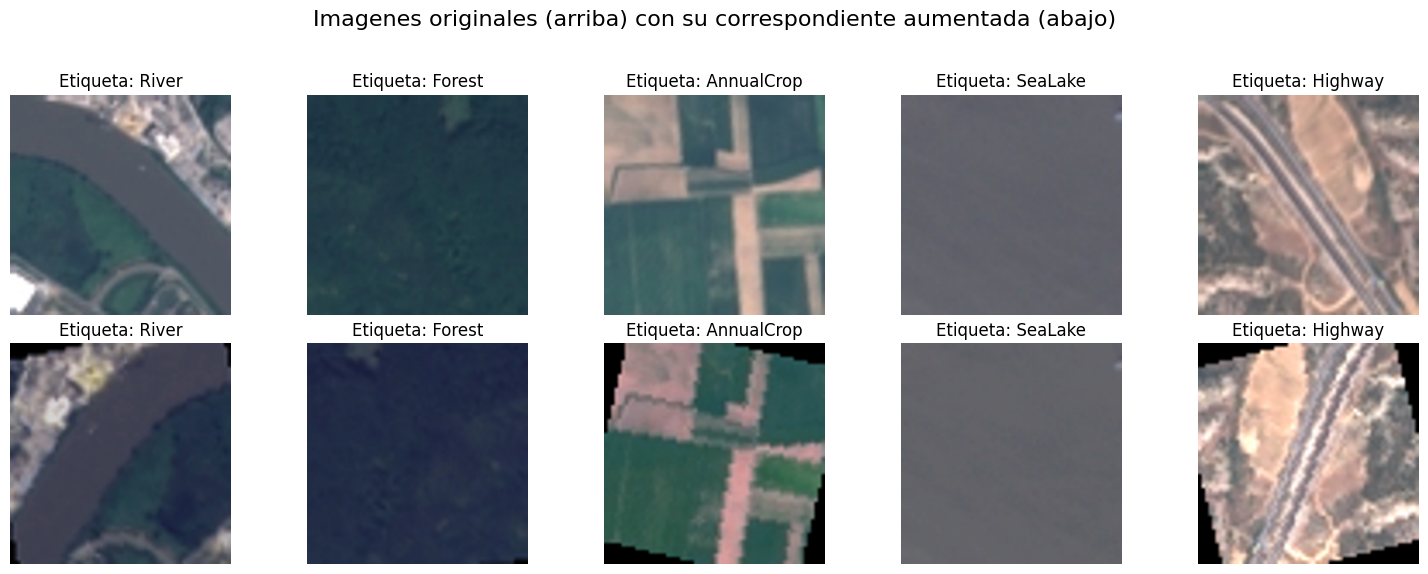

In [43]:
random_idx = random.sample(range(len(dataset["train"])), 5)
plot_subset = dataset["train"].select(random_idx)

raw_plot_subset = plot_subset.with_transform(lambda x: transforms(x, train=False))
raw_dataloader = DataLoader(raw_plot_subset, batch_size=5, shuffle=False)

aug_plot_subset = plot_subset.with_transform(lambda x: transforms(x, train=True))
aug_dataloader = DataLoader(aug_plot_subset, batch_size=5, shuffle=False)

# Get and unnormalize raw images
raw_batch = next(iter(raw_dataloader))
raw_images = [TF.to_pil_image(transforms.unnormalize(img)) for img in raw_batch["pixel_values"]]

# Get and unnormalize augmented images
aug_batch = next(iter(aug_dataloader))
aug_images = [TF.to_pil_image(transforms.unnormalize(img)) for img in aug_batch["pixel_values"]]

plot_labels = [id2label[int(x)] for x in raw_batch["label"]] * 2

# Plot images
show_image_grid(
    data={"images": raw_images + aug_images, "labels": plot_labels},
    title="Imagenes originales (arriba) con su correspondiente aumentada (abajo)",
    num_cols=5,
)

In [ ]:
# Aplicamos las transformaciones
def train_transform_wrapper(example):
    return transforms(example, train=True)


def test_transform_wrapper(example):
    return transforms(example, train=False)


encoded_ds = {
    "train": dataset["train"].with_transform(train_transform_wrapper),
    "test": dataset["test"].with_transform(test_transform_wrapper),
}

# Mostramos un ejemplo de la estructura.
print(encoded_ds["train"][0])
print(encoded_ds["test"][0]["pixel_values"].shape)

{'pixel_values': tensor([[[-0.3541, -0.3541, -0.3712,  ..., -0.9020, -1.0048, -1.0562],
         [-0.3541, -0.3541, -0.3712,  ..., -0.9020, -1.0048, -1.0562],
         [-0.3712, -0.3712, -0.3712,  ..., -0.9020, -1.0048, -1.0562],
         ...,
         [-0.3712, -0.3883, -0.4054,  ..., -1.7925, -1.7925, -1.7925],
         [-0.3712, -0.3883, -0.4054,  ..., -1.7925, -1.7925, -1.7925],
         [-0.3712, -0.3883, -0.4054,  ..., -1.7925, -1.7925, -1.7925]],

        [[-0.3025, -0.3025, -0.3025,  ..., -0.8277, -0.9328, -0.9678],
         [-0.3025, -0.3025, -0.3025,  ..., -0.8277, -0.9328, -0.9678],
         [-0.3025, -0.3025, -0.3025,  ..., -0.8277, -0.9328, -0.9678],
         ...,
         [-0.3375, -0.3550, -0.3725,  ..., -1.7031, -1.7031, -1.7031],
         [-0.3375, -0.3550, -0.3725,  ..., -1.7031, -1.7031, -1.7031],
         [-0.3375, -0.3550, -0.3725,  ..., -1.7031, -1.7031, -1.7031]],

        [[-0.0092, -0.0092, -0.0092,  ..., -0.4798, -0.6018, -0.6541],
         [-0.0092, -0.0092, 

## 4. Definición de las métricas de evaluación <a name="metrics"></a>

In [45]:
clf_metrics = evaluate.combine([
    MulticlassAccuracy(),  # Precisión multicategoría.
    evaluate.load("f1"), # Puede ser "micro", "macro" o "weighted". En este caso, "weighted" toma en cuenta el desbalanceo leve de clases.
    evaluate.load("precision"), # "marco" para clases desbalanceadas.
    evaluate.load("recall")
])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels, average="weighted")

## 5. Entrenamiento del modelo <a name="entrenamiento"></a>

In [46]:
training_args = TrainingArguments(
    output_dir=MODELS_DIR / MODEL_FOLDER,  
    overwrite_output_dir=True,  
    eval_strategy="epoch",  
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    eval_accumulation_steps=1, 
    learning_rate=5e-5,  
    num_train_epochs=10,
    fp16=True,  
    warmup_ratio=0.1,   
    save_strategy="best", 
    save_total_limit=1, 
    logging_strategy="epoch",  
    seed=RANDOM_SEED,  
    remove_unused_columns=False,  
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",
    greater_is_better=True,
    # dataloader_num_workers=4,
    report_to=[],
)

> 📝 <em><font color='Gray'>Nota:</font></em> Si no se estima o tiene una noción de los hiperparámetros, se pueden buscar con:
> ```python
> def optuna_hp_space(trial):
>     return {
>         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True),
>         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
>         "eval_accumulation_steps": trial.suggest_int("eval_accumulation_steps", 1, 8),
>         
>     }
> 
> def model_init(trial):
>     return CvtForImageClassification.from_pretrained(
>         CHECKPOINT,
>         num_labels=len(labels),
>         id2label=id2label,
>         label2id=label2id,
>         ignore_mismatched_sizes=True,  # Ignora tamaños de pesos que no coinciden (útil si se cambia el número de clases).
> )
> 
> trainer = Trainer(
>     model=None,   
>     args=training_args,
>     data_collator=data_collator,   
>     train_dataset=encoded_ds['train'], 
>     eval_dataset=encoded_ds['test'],   
>     processing_class=image_processor,
>     compute_metrics=compute_metrics,
>     model_init=model_init,  # Inicialización del modelo para Optuna.
>     callbacks=callback_list, 
> )
> 
> best_trial = trainer.hyperparameter_search(
>     direction="minimize",
>     backend="optuna",
>     hp_space=optuna_hp_space,
>     n_trials=5,
> )
> ```

In [47]:
data_collator = DefaultDataCollator()

callback_list = [EarlyStoppingCallback(early_stopping_patience=2), MLflowCallback()]

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["test"],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    callbacks=callback_list
)

In [48]:
with mlflow.start_run():
    mlflow.log_param("transforms", str(transforms.transforms_to_string()))
    mlflow.log_param("dataset_name", DATASET_NAME)
    mlflow.log_param("dataset_version", DATASET_VERSION)

    logger.info("Iniciando entrenamiento del modelo...")
    trainer.train()
    logger.info("Entrenamiento finalizado. Guardando el modelo...")

history = pd.DataFrame(trainer.state.log_history)
history.to_csv(MODELS_DIR / MODEL_FOLDER / HISTORY_FILENAME, index=False)
history

2025-06-18 18:13:29.167 | INFO     | __main__:<module>:6 - Iniciando entrenamiento del modelo...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.140200,0.177471,0.944815,0.944266,0.946002,0.944815
2,0.588100,0.174453,0.943333,0.943276,0.947589,0.943333
3,0.529300,0.089457,0.967778,0.968029,0.970623,0.967778
4,0.512500,0.066448,0.980370,0.980407,0.980633,0.980370
5,0.485900,0.083747,0.974074,0.974207,0.975457,0.974074
6,0.485000,0.072071,0.976296,0.976442,0.977171,0.976296


2025-06-18 18:26:31.627 | INFO     | __main__:<module>:8 - Entrenamiento finalizado. Guardando el modelo...
🏃 View run defiant-smelt-257 at: http://localhost:8080/#/experiments/5/runs/caad497a1f1f48c0b938fc015ebe426b
🧪 View experiment at: http://localhost:8080/#/experiments/5


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.1402,29.820477,0.000049,1.0,380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,380,0.177471,0.944815,0.944266,0.946002,0.944815,18.1838,148.484,2.365,NaN,NaN,NaN,NaN,NaN
2,0.5881,36.032692,0.000045,2.0,760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,760,0.174453,0.943333,0.943276,0.947589,0.943333,6.0460,446.580,7.112,NaN,NaN,NaN,NaN,NaN
4,0.5293,29.734167,0.000039,3.0,1140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,3.0,1140,0.089457,0.967778,0.968029,0.970623,0.967778,5.9783,451.636,7.193,NaN,NaN,NaN,NaN,NaN
6,0.5125,13.395435,0.000033,4.0,1520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,1520,0.066448,0.980370,0.980407,0.980633,0.980370,6.0585,445.654,7.097,NaN,NaN,NaN,NaN,NaN
8,0.4859,0.702020,0.000028,5.0,1900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,5.0,1900,0.083747,0.974074,0.974207,0.975457,0.974074,6.1320,440.314,7.012,NaN,NaN,NaN,NaN,NaN


In [ ]:
# # Save trained model weights
# trained_model = trainer.model
# torch.save(trained_model.state_dict(), MODELS_DIR / MODEL_FOLDER / "weights.pt")

# Load trained model weights
trainer.model.load_state_dict(torch.load(MODELS_DIR / MODEL_FOLDER / "weights.pt"))

In [49]:
logger.info("Evaluando el modelo...")
metrics = trainer.evaluate()
logger.info("Evaluación finalizada. Métricas:")

metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df.to_csv(MODELS_DIR / MODEL_FOLDER / METRICS_FILENAME, index=False)
metrics_df

2025-06-18 18:27:22.115 | INFO     | __main__:<module>:1 - Evaluando el modelo...


2025-06-18 18:27:28.832 | INFO     | __main__:<module>:3 - Evaluación finalizada. Métricas:


,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.072071,0.976296,0.976442,0.977171,0.976296,6.5239,413.865,6.591,6.0


In [50]:
# Guardamos las predicciones del modelo en el conjunto de test
predictions_output = trainer.predict(encoded_ds["test"])

# Probabilidades
y_probs = predictions_output.predictions

# Predicciones finales (argmax)
y_pred = np.argmax(y_probs, axis=1)

# Etiquetas reales
y_true = predictions_output.label_ids

results_df = pd.DataFrame(
    {
        "y_true": [id2label[i] for i in y_true],
        "y_pred": [id2label[i] for i in y_pred],
    }
)
results_df.to_csv(MODEL_FOLDER / PREDICTIONS_FILENAME, index=False)

## 6. Resultados <a name="resultados"></a>

In [51]:
history = pd.read_csv(MODEL_FOLDER / HISTORY_FILENAME)
results_df = pd.read_csv(MODEL_FOLDER / PREDICTIONS_FILENAME)
y_true = results_df["y_true"].values
y_pred = results_df["y_pred"].values

In [52]:
plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    labels=sorted(set(y_true)),
    filename=CHECKPOINT.replace("/", "-") + "_confusion_matrix",
    dirpath=FIGURES_DIR / MODEL_NAME,
    show_as_percentaje=True
)

In [53]:
# Filtramos solo las filas que tienen datos útiles
filtered_history = history.copy()
filtered_history = filtered_history[filtered_history["epoch"].notna()]

# Plot de pérdidas (loss)
plot_metric(
    filtered_history,
    x_col="epoch",
    y_cols=["loss", "eval_loss"],
    y_labels=["Pérdida de entrenamiento", "Pérdida de evaluación"],
    title="Pérdida por época",
    filename=CHECKPOINT.replace("/", "-") + "_loss_plot",
    dirpath=FIGURES_DIR / MODEL_NAME,
)

# Plot de accuracy
if "eval_accuracy" in filtered_history.columns:
    plot_metric(
        filtered_history[filtered_history["eval_accuracy"].notna()],
        x_col="epoch",
        y_cols=["eval_accuracy"],
        y_labels=["Accuracy de evaluación"],
        title="Accuracy por época",
        filename=CHECKPOINT.replace("/", "-") + "_accuracy_plot",
        dirpath=FIGURES_DIR / MODEL_NAME,
    )